In [1]:
import sys # for gioia to load aiohttp
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

In [2]:
# load data
with open('data/prices_include.json') as f:    
    stock_data_include = json.load(f)
with open('data/prices_exclude.json') as f:    
    stock_data_exclude = json.load(f)

# keep track of which stocks are included/excluded from the database
stocks_include = list(stock_data_include.keys())
stocks_exclude = list(stock_data_exclude.keys())
    
# check the number of market days in the year
num_days = len(stock_data_include[stocks_include[0]])

# Time Series Database

Gioia Dominedo  
Nicolas Drizard  
Kendrick Lo  

## Persistence Architecture

<img src='img/db_structure.png'>

## Additional Feature:  
## iSAX Similarity Searches

* A time series T of length n can be converted into a SAX representation
  * approximates T using a smaller number of segments (e.g. w=4)
  * each segment is represented by a discrete number
  * result is a SAX word (i.e. a vector) such as {11, 11, 01, 00}

<img src='img/slide1.png'>

* The SAX representation can be used as an index
  * e.g. fixed cardinality of 8, word length of 4
  * An example T may map to {68, 68, 38, 08} 
    * data for all Ts that can be represented by this SAX word can be stored in the same text file on disk (e.g. with name **6.8_6.8_3.8_0.8.txt**)
* **Problem**: storage imbalance
* **Solution**: introduce a threshold for the number of time series that can be stored in a single file
  * If an insertion would cause threshold to be exceeded, **split the file**

* The diagram below illustrates an iSAX index as a tree
  * **root node**: represents complete SAX space
  * **terminal node**: leaf node containing pointer to file on disk
    * **SAX word** as index, contents are the actual time series data
  * **internal node** (new): designates split in SAX space
    * created when number of entries in a terminal node exceeds threshold

<img src='img/slide3.png'>

* Observations:
  * **binary** splits are along one dimension (sequentially) 
    * creates two new words of increased cardinality
  * “new” node splitting policy (iSAX 2.0) purports to provide better balance by determining optimal dimension
    * checks whether mean value is close to a breakpoint
* However:
  * balancing problems still exist
  * no justification given for binary splits
    * note that root is connected to multiple nodes


<img src='img/slide5.png'>

* We implemented iSAX tree as a “true” n-ary tree
  * splits series in a “full” terminal node into up to ‘n’ terminal nodes all located at the same depth in the tree
  * achieves better balance, faster traversals
* Class methods:
  * insert, delete, preorder (x2), similarity search (find_nbr)

* Similarity search is **“approximate”**
  * intuition is that two similar time series are often  represented by the same iSAX word
  * natural clustering
  * “ties” broken by computing Euclidean distance (but only for neighbors)
   * adjust for sparser nodes by implementing search for series with common parent

<img src='img/slide7.png'>

## Stock Market Example

In [3]:
# load the database server
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(num_days), '--data_dir', '../db_files', '--db_name', 'stock_prices'])

# load the database webserver
webserver = subprocess.Popen(['python', '../go_webserver.py'])

# import the web interface and initialize it
from webserver import *
web_interface = WebInterface()

In [4]:
len(web_interface.select())

350

In [5]:
# let's look at the first 10 stocks
web_interface.select(fields=None, additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('A', OrderedDict()),
             ('AA', OrderedDict()),
             ('ABC', OrderedDict()),
             ('ABT', OrderedDict()),
             ('ADI', OrderedDict()),
             ('ADM', OrderedDict()),
             ('AEE', OrderedDict()),
             ('AEP', OrderedDict()),
             ('AES', OrderedDict()),
             ('AET', OrderedDict())])

## Vantage Point Search

In [6]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
print('Most similar stock:', list(result)[0])

Stock: TMK
Most similar stock: LTD


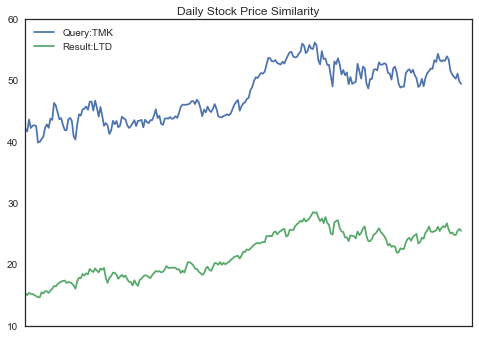

In [7]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_data_include[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

## iSAX Tree Search

In [8]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the isax tree similarity search
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))

if result == 'ERROR: NO_MATCH':
    print('Could not find a similar stock.')
else:
    print('Most similar stock:', list(result)[0])

Stock: HCP
Most similar stock: RSG


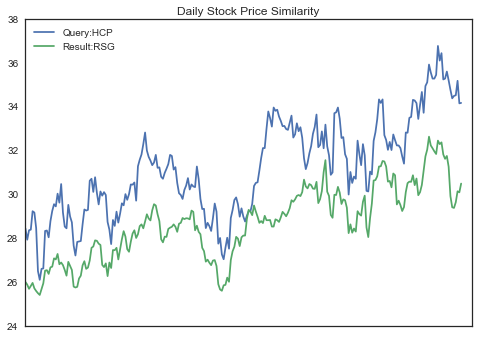

In [9]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_data_include[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

## Comparing Similarity Searches

In [10]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result_vp = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
print('VP search result:', list(result_vp)[0])

# run the isax similarity search
result_isax = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))
if result_isax == 'ERROR: NO_MATCH':
    print('iSAX search result: Could not find a similar stock.')
else:
    print('iSAX search result:', list(result_isax)[0])

Stock: SPG
VP search result: VNO
iSAX search result: VNO


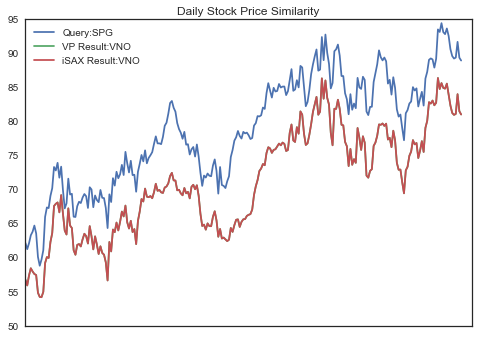

In [11]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_data_include[list(result_vp)[0]], label='VP Result:' + list(result_vp)[0])
plt.plot(stock_data_include[list(result_isax)[0]], label='iSAX Result:' + list(result_isax)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

## iSAX Tree Representation

In [12]:
print(web_interface.isax_tree())

root
--->['00', '10', '01', '11']: 0 []
------>['001', '100', '011', '111']: 2 ['STT', 'WFR']
------>['001', '101', '010', '110']: 2 ['JCP', 'OI']
------>['001', '100', '010', '111']: 1 ['KSS']
------>['001', '100', '011', '110']: 1 ['IGT']
------>['001', '101', '011', '110']: 1 ['MUR']
------>['000', '100', '011', '110']: 1 ['TSO']
------>['001', '100', '010', '110']: 1 ['JPM']
--->['10', '11', '01', '00']: 3 ['FIS', 'HSY', 'SUN']
--->['11', '10', '00', '01']: 0 []
------>['110', '101', '000', '011']: 0 []
--------->['1100', '1010', '0001', '0111']: 1 ['XRX']
--------->['1101', '1011', '0001', '0110']: 2 ['PH', 'TGT']
--------->['1101', '1010', '0001', '0111']: 1 ['HD']
--------->['1100', '1011', '0001', '0111']: 1 ['VFC']
--------->['1101', '1010', '0001', '0110']: 2 ['GNW', 'HON']
------>['111', '100', '001', '010']: 0 []
--------->['1110', '1000', '0010', '0101']: 4 ['F', 'LUV', 'SNA', 'WYN']
--------->['1110', '1001', '0010', '0101']: 3 ['CBS', 'DOV', 'EMR']
--------->['1110', '10

In [13]:
server.terminate()
webserver.terminate()
web_interface = None